# Preparation

## Import packages

In [1]:
from src.helper_functions import add_metadata, add_ephys_prop
import anndata
import scquint.data
import pickle
import pyarrow.parquet as pq
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing.pool as mp
from scquint.data import calculate_PSI

## Define paths

In [2]:
# Paths
path_to_transcriptomic_ID_ttype = "proc/transcriptomic_ID_ttype.json"
output_dir = "proc/response_to_reviewers/"
gtf_path = "/external/rprshnas01/netdata_kcni/stlab/Genomic_references/Ensembl/Mouse/Release_110/Mus_musculus.GRCm39.110.gtf"
with open("proc/IC_list.json", "r") as f:
    IC_list = json.load(f)

# Start here

## read in the intron count matrix and features

In [14]:
X = pq.read_table(f"{output_dir}X.parquet").to_pandas()
features = pq.read_table(f"{output_dir}features.parquet").to_pandas()
features.strand.replace({"0": "NA", "1": "+", "2": "-"}, inplace=True)
transcriptomic_ID_ttype = json.load(open(path_to_transcriptomic_ID_ttype, "r"))


In [5]:
print(
    f"{len(transcriptomic_ID_ttype)} cells that have t-type assignment, these cells passed QC"
    )

4270 cells that have t-type assignment, these cells passed QC


In [51]:
X = X.assign(ttype = X.index.map(transcriptomic_ID_ttype))

In [2]:
n_min_cells_per_ttype = [1, 5, 10, 20, 25, 30, 35, 40, 45, 50]

In [55]:
def run(params):
    n, _ = params
    X_subset = X.groupby("ttype").filter(lambda x: x.shape[0] >= n)
    ind = np.hstack(X_subset.groupby("ttype").apply(lambda x: np.random.choice(x.index, size = n, replace = False)).values)
    X_subset = X_subset.loc[ind]
    X_subset = X_subset.groupby("ttype").sum()

    # construct adata object from intron count matrix
    adata = anndata.AnnData(X_subset, dtype=np.int64)
    adata.var = features

    # add gene annotation
    adata = scquint.data.add_gene_annotation(adata, gtf_path)

    # remove weird chromosomes
    adata = adata[:, np.where(adata.var.index.str.startswith("nan") == False)[0]]

    # group introns
    adata.var.strand = adata.var.strand.astype("str")
    adata_three = scquint.data.group_introns(adata, "three_prime")

    # calculate PSI
    adata_three.layers["PSI"] = calculate_PSI(adata_three, smooth=False)

    n_introns_detected_three = (np.isnan(adata_three.layers["PSI"]).sum(axis=0) < 5).sum()
    return pd.Series({n: n_introns_detected_three})

In [ ]:
pool = mp.Pool(processes=10)
results = pool.map(run, [(n, i) for n in n_min_cells_per_ttype for i in range(10)])
pd.concat(results).to_csv(f"proc/n_introns_detected_three.csv")

# How many isoforms are undiscovered due to insufficient coverage?

In [54]:
true_indices = features.groupby("start").size() > 1
true_indices = true_indices.where(true_indices == True).dropna().index.tolist()
num_shared_start_sites = features.loc[features.start.isin(true_indices)].shape[0]

true_indices = features.groupby("end").size() > 1
true_indices = true_indices.where(true_indices == True).dropna().index.tolist()
num_shared_end_sites = features.loc[features.end.isin(true_indices)].shape[0]

In [6]:
import numpy as np

In [8]:
[i for i in range(1)]

[0]

In [59]:
total_isoforms = num_shared_start_sites+num_shared_end_sites

In [2]:
with open("/external/rprshnas01/netdata_kcni/stlab/Nuo/CIHR/proc/adata_three_tt.pkl", "rb") as f:
    adata_three_tt = pickle.load(f)
with open("/external/rprshnas01/netdata_kcni/stlab/Nuo/CIHR/proc/adata_five_tt.pkl", "rb") as f:
    adata_five_tt = pickle.load(f)   

In [ ]:
rsync -r source_directory/ destination_directory/

In [ ]:
adata_three_tt.varm["p_value"].flatten()

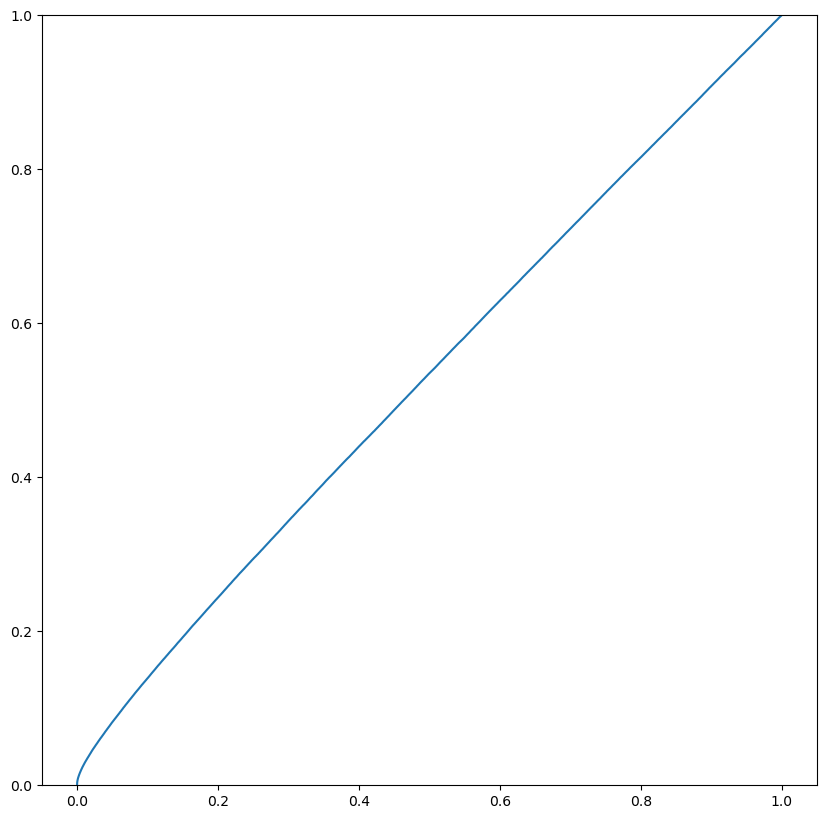

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.ecdf(adata_three_tt.varm["p_value"].flatten(), label="3' TT")
# plt.plot(adata_three_tt.varm["p_value"].flatten(), adata_three_tt.varm["p_value"].flatten().cumsum())

(array([118735.,  89545.,  84968.,  82615.,  81271.,  80475.,  79889.,
         79198.,  79004.,  78652.]),
 array([1.01166073e-14, 9.99997244e-02, 1.99999449e-01, 2.99999173e-01,
        3.99998897e-01, 4.99998622e-01, 5.99998346e-01, 6.99998070e-01,
        7.99997795e-01, 8.99997519e-01, 9.99997244e-01]),
 <BarContainer object of 10 artists>)

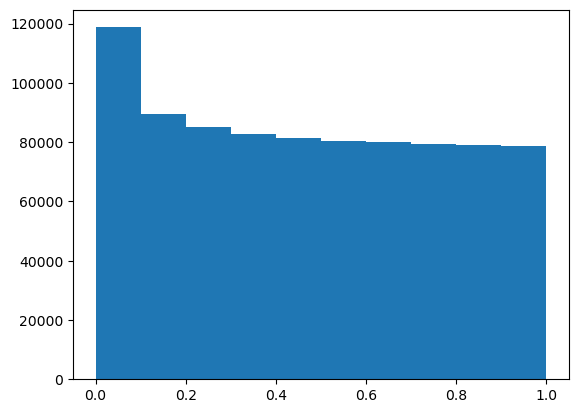

In [5]:
plt.hist(adata_three_tt.varm["p_value"].flatten())

(array([102220.,  83727.,  80562.,  80343.,  79073.,  79094.,  78774.,
         77992.,  77681.,  77686.]),
 array([3.01321435e-15, 9.99999990e-02, 1.99999998e-01, 2.99999997e-01,
        3.99999996e-01, 4.99999995e-01, 5.99999994e-01, 6.99999993e-01,
        7.99999992e-01, 8.99999991e-01, 9.99999990e-01]),
 <BarContainer object of 10 artists>)

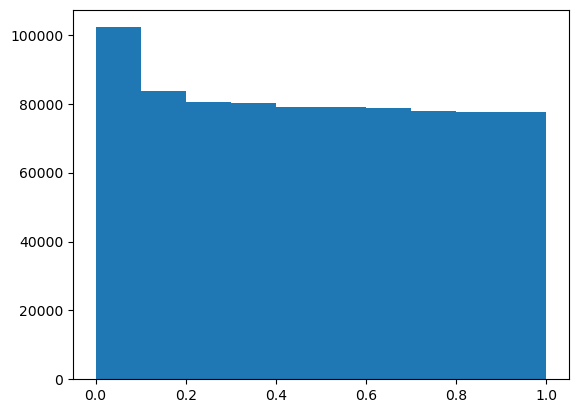

In [6]:
plt.hist(adata_five_tt.varm["p_value"].flatten())

In [26]:
np.count_nonzero(adata_five_tt[:, adata_five_tt.var.gene_name.isin(IC_list["VGIC_LGIC"])].varm["fdr"].sum(axis=1))

39

In [27]:
np.count_nonzero(adata_three_tt[:, adata_three_tt.var.gene_name.isin(IC_list["VGIC_LGIC"])].varm["fdr"].sum(axis=1))

53

In [28]:
53+39

92

In [ ]:
adata_three_tt.layers["PSI"] = calculate_PSI(adata_three_tt, smooth=False)
adata_five_tt.layers["PSI"] = calculate_PSI(adata_five_tt, smooth=False) 

In [70]:
num_isoforms_explored = (np.isnan(adata_three_tt.layers["PSI"]).sum(axis=0) < 5).sum() + (np.isnan(adata_five_tt.layers["PSI"]).sum(axis=0) < 5).sum()

In [72]:
1- num_isoforms_explored/total_isoforms

0.15605378749090515

# Relationship between num of cells pooled and num. isoforms detected

In [7]:
n_introns_detected_three = pd.read_csv("proc/n_introns_detected_three.csv", index_col=0)
n_introns_detected_three = n_introns_detected_three.reset_index().groupby("index").mean()

In [8]:
n_introns_detected_three

,0
index,
0,35680.00
5,9630.85
10,17684.70
15,22744.60
20,25903.90


## Visualization

### Number of cells pooled for each ttype

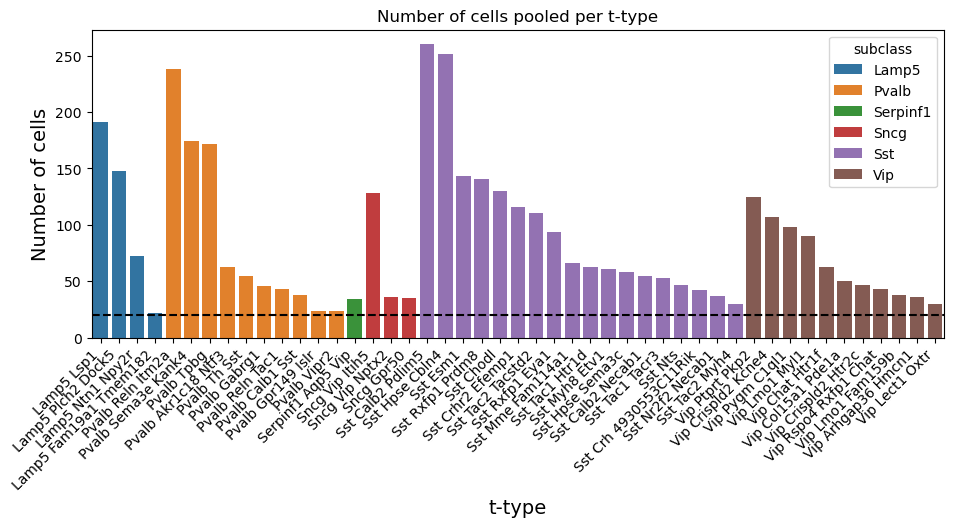

In [106]:
df = X.loc[:, [0, "ttype"]].groupby("ttype").count().reset_index().rename(columns = {0: "count"})
# df = df.sort_values("count", ascending = False)
df = df.assign(subclass = df.ttype.str.split(" ", expand=True)[0]) 
df = df.groupby("subclass").apply(lambda x: x.sort_values("count", ascending = False))

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
sns.barplot(df, x="ttype", y="count", hue="subclass", ax=ax, dodge=False)
ax.axhline(20, ls="--", color="black")
text = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
title = ax.set_title("Number of cells pooled per t-type")
xlabel = ax.set_xlabel("t-type", fontsize=14)
ylabel = ax.set_ylabel("Number of cells", fontsize=14)

### Percentage of introns unexplored

### Relatioship between num of introns detected and cells pooled

Compute n. introns detected with different number of cells pooled per t-type

In [15]:
min_ephys_prop_list = [1, 2, 4, 6, 8]

In [11]:
min_ephys_prop_list = [1, 4]

In [36]:
def run(n):    
    ind = np.hstack(X.groupby("ttype").apply(lambda x: np.random.choice(x.index, size = n, replace = False)).values)
    X_subset = X.loc[ind]
    X_subset = X_subset.groupby("ttype").sum()

    # construct adata object from intron count matrix
    adata = anndata.AnnData(X_subset, dtype=np.int64)
    adata.var = features

    # add gene annotation
    adata = scquint.data.add_gene_annotation(adata, gtf_path)

    # remove weird chromosomes
    adata = adata[:, np.where(adata.var.index.str.startswith("nan") == False)[0]]

    # group introns
    adata.var.strand = adata.var.strand.astype("str")
    adata_three = scquint.data.group_introns(adata, "three_prime")
    adata_five = scquint.data.group_introns(adata, "five_prime")

    # calculate PSI
    adata_three.layers["PSI"] = calculate_PSI(adata_three, "smooth")
    adata_five.layers["PSI"] = calculate_PSI(adata_five, "smooth")

    # add ephys props to adata objects
    adata_three = add_ephys_prop(adata_three)
    adata_five = add_ephys_prop(adata_five)

    # add cor, p, fdr
    adata_three = add_metadata(adata_three)
    adata_five = add_metadata(adata_five)

    row_three = ",".join([((adata_three.varm["fdr"].sum(axis=1) > n).sum()).astype("str") for n in min_ephys_prop_list])
    row_three = str(n) + "," + row_three + "\n"
    with open("proc/n_introns_detected_three.csv",'a') as file:
        file.write(row_three)
    
    row_five = ",".join([((adata_five.varm["fdr"].sum(axis=1) > n).sum()).astype("str") for n in min_ephys_prop_list])
    row_five = str(n) + "," + row_five + "\n"
    with open("proc/n_introns_detected_five.csv",'a') as file:
        file.write(row_five)

In [39]:
n_list = [1, 5, 10, 15, 20]
with open("proc/n_introns_detected_three.csv",'w') as file:
    pass
with open("proc/n_introns_detected_five.csv",'w') as file:
    pass

results = Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list) ''


Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)
Parallel(n_jobs=len(n_list))(delayed(run)(n) for n in n_list)

n_introns_detected_three = pd.read_csv("proc/n_introns_detected_three.csv", index_col=0, names = min_ephys_prop_list).sort_index().reset_index(names="min_cells")
n_introns_detected_five = pd.read_csv("proc/n_introns_detected_five.csv", index_col=0, names = min_ephys_prop_list).sort_index().reset_index(names="min_cells")

/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index."

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 20

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to 

Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 20

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_

Filtering to introns associated to 1 and only 1 gene.
Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, in

Filtering to introns associated to 1 and only 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning:

Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering to introns associated to 1 and only 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n

Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.
Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering to introns associated to 1 and only 1 gene.


/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:137: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_out.var["gene_id"] = adata_out.var.gene_id_list
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/python_pkgs/scquint/scquint/data.py:219: RuntimeWarning: invalid value encountered in divide
  X = X + intron_sum / intron_group_sum[groups]
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value
/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/pandas/core/generic.py:6234: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/external/rprshnas01/kcni/nxu/utility/utility/utils.py:2004: RuntimeWarning: invalid value encountered in divide
  c /= X.std(axis=int(rowvar), ddof=ddof)[:, None]


Plotting

In [44]:
n_introns_detected_three.groupby("min_cells").mean()

,1,2,4,6,8
min_cells,,,,,
1,327.4,307.9,4.2,0.0,0.0
5,457.5,390.2,14.3,1.4,0.4
10,353.4,271.2,19.1,2.7,0.4
15,322.0,229.1,29.8,7.5,3.0
20,341.8,228.7,40.2,12.1,3.2


/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

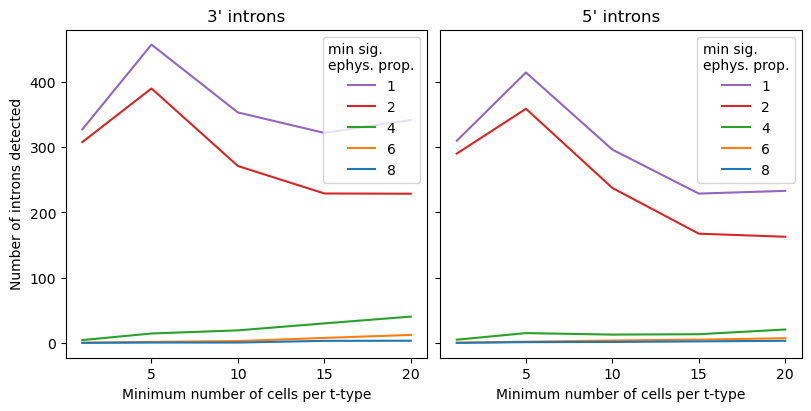

In [55]:
color_list = sns.color_palette()[:len(min_ephys_prop_list)][::-1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), layout = "constrained", sharey=True)
for min_ephys_prop, color in zip(min_ephys_prop_list, color_list):
    sns.lineplot(n_introns_detected_three.groupby("min_cells", as_index=False).mean(), x="min_cells", y=min_ephys_prop, color=color, ax=ax1, label=str(min_ephys_prop))
    sns.lineplot(n_introns_detected_five.groupby("min_cells", as_index=False).mean(), x="min_cells", y=min_ephys_prop, color=color, ax=ax2, label=str(min_ephys_prop))
ax1.set_ylabel("Number of introns detected")    
ax1.set_xlabel("Minimum number of cells per t-type")
ax2.set_xlabel("Minimum number of cells per t-type")
ax1.set_title("3' introns")
ax2.set_title("5' introns")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc="upper right", title="min sig.\nephys. prop.", frameon=True)
ax2.legend(handles, labels, loc="upper right", title="min sig.\nephys. prop.", frameon=True)
# fig.legend(handles, labels, loc="outside right", title="min sig. ephys. prop.", frameon=True)
# fig.legend(loc="outside right", title="min ephys prop", frameon=True)

In [56]:
n_introns_detected_three_subset = n_introns_detected_three.loc[:, ["min_cells", 1, 2, 4]]
n_introns_detected_five_subset = n_introns_detected_five.loc[:, ["min_cells", 1, 2, 4]]
min_ephys_prop_list_subset = [1, 2, 4]

/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

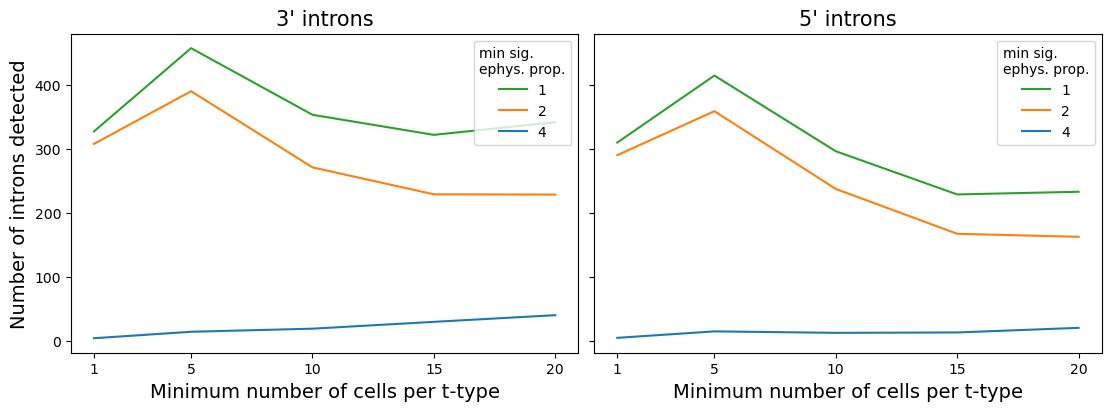

In [112]:
color_list = sns.color_palette()[:len(min_ephys_prop_list_subset)][::-1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), layout = "constrained", sharey=True)
for min_ephys_prop, color in zip(min_ephys_prop_list, color_list):
    sns.lineplot(n_introns_detected_three_subset.groupby("min_cells", as_index=False).mean(),
                x="min_cells", y=min_ephys_prop, color=color, ax=ax1, label=str(min_ephys_prop))
    sns.lineplot(n_introns_detected_five_subset.groupby("min_cells", as_index=False).mean(),
                 x="min_cells", y=min_ephys_prop, color=color, ax=ax2, label=str(min_ephys_prop))
ax1.set_ylabel("Number of introns detected", fontsize=14)    
ax1.set_xlabel("Minimum number of cells per t-type", fontsize=14)
ax2.set_xlabel("Minimum number of cells per t-type", fontsize=14)
ax1.set_title("3' introns", fontsize=15)
ax2.set_title("5' introns", fontsize=15)
ax1.set_xticks(n_list)
ax2.set_xticks(n_list)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc="upper right", title="min sig.\nephys. prop.", frameon=True)
ax2.legend(handles, labels, loc="upper right", title="min sig.\nephys. prop.", frameon=True)
# fig.legend(handles, labels, loc="outside right", title="min sig. ephys. prop.", frameon=True)
# fig.legend(loc="outside right", title="min ephys prop", frameon=True)

### median z-scores

In [144]:
ephys_data_tt = pd.read_csv("/nethome/kcni/nxu/CIHR/proc/ephys_data_tt.csv", index_col=0)
ephys_data_tt = ((ephys_data_tt-ephys_data_tt.mean(axis=0)) / ephys_data_tt.std(axis=0)).reset_index(names="ttype")

Each obeservation here is the median z-score of ephys props of all cells within a cell type

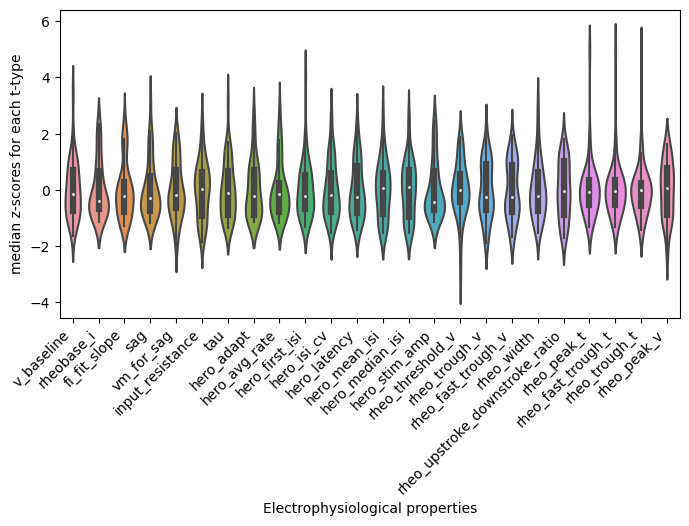

In [189]:
plt.figure(figsize=(8, 4))
ephys_data_tt.melt(id_vars="ttype")\
    .pipe(sns.violinplot, x="variable", y="value", alpha=.25)
plt.xlabel("Electrophysiological properties")
plt.ylabel("median z-scores for each t-type")

xticks = plt.xticks(rotation=45, ha='right')

### standard deviation of zscores

In [59]:
ephys_prop_sc = pd.read_csv("proc/ephys_data_sc.csv", index_col=0)
ephys_prop_sc = (ephys_prop_sc-ephys_prop_sc.mean(axis=0))/ephys_prop_sc.std(axis=0)
ephys_prop_sc = ephys_prop_sc.assign(ttype = ephys_prop_sc.index.map(transcriptomic_ID_ttype))

In [78]:
ephys_prop_sc.ttype.isin(ephys_prop_sc.ttype.unique()[:10])

cell_specimen_id
SM-GE8WI_E1-50_CTGGTTCT-CCACAACA         True
SM-GE4WN_E1-50_CTACAAGTTC-TTCATGGTGC     True
SM-GE94H_E1-50_ACGACTTG-TAGGAGCT         True
SM-GE8X4_E1-50_TCGCTGTT-CATCACGT         True
SM-GE8XZ_E1-50_TACGCCTT-ACACCGAT         True
                                        ...  
SM-GE5UX_E1-50_TATCAGCG-AACTGAGG        False
SM-GE5VJ_E1-50_TGGAGAGT-GATCTTGC        False
SM-GE4RC_E1-50_GTTGCGAT-CTATGCCT        False
SM-GE8WI_E1-50_GTGTTCCT-CCAGTTGA        False
SM-GE4QV_E1-50_CCAAGACT-CCAAGGTT        False
Name: ttype, Length: 4100, dtype: bool

/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nethome/kcni/nxu/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


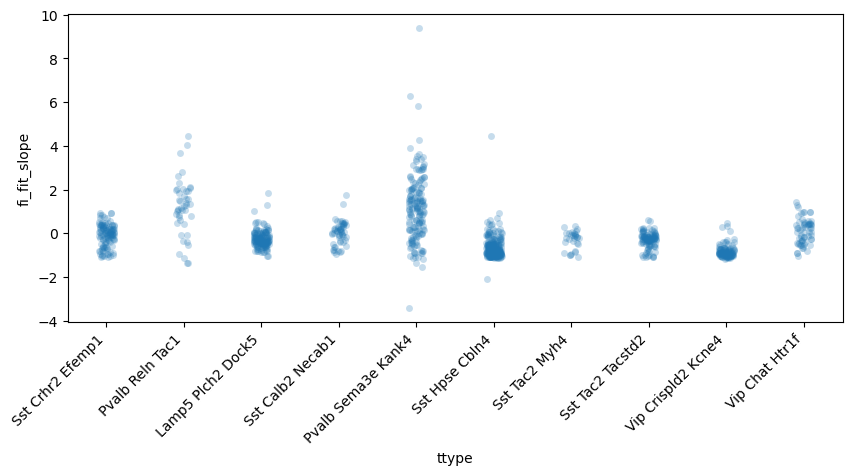

In [114]:
plt.figure(figsize=(10, 4))
ephys_prop_sc.loc[ephys_prop_sc.ttype.isin(ephys_prop_sc.ttype.unique()[:10]), ["fi_fit_slope", "ttype"]]\
    .pipe(sns.stripplot, x="ttype", y="fi_fit_slope", alpha=.25)
text = plt.xticks(rotation=45, ha='right')

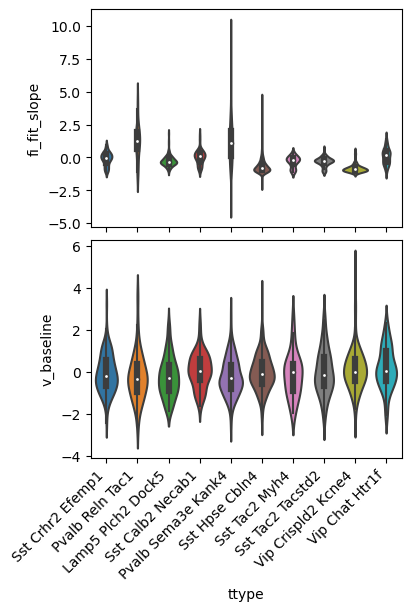

In [113]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), layout = "constrained", sharex=True)
ephys_prop_sc.loc[ephys_prop_sc.ttype.isin(ephys_prop_sc.ttype.unique()[:10]), ["fi_fit_slope", "ttype"]]\
    .pipe(sns.violinplot, x="ttype", y="fi_fit_slope", alpha=.25, ax=ax1)
ax1.set_xlabel("")
ephys_prop_sc.loc[ephys_prop_sc.ttype.isin(ephys_prop_sc.ttype.unique()[:10]), ["v_baseline", "ttype"]]\
    .pipe(sns.violinplot, x="ttype", y="v_baseline", alpha=.25)
text = plt.xticks(rotation=45, ha='right')

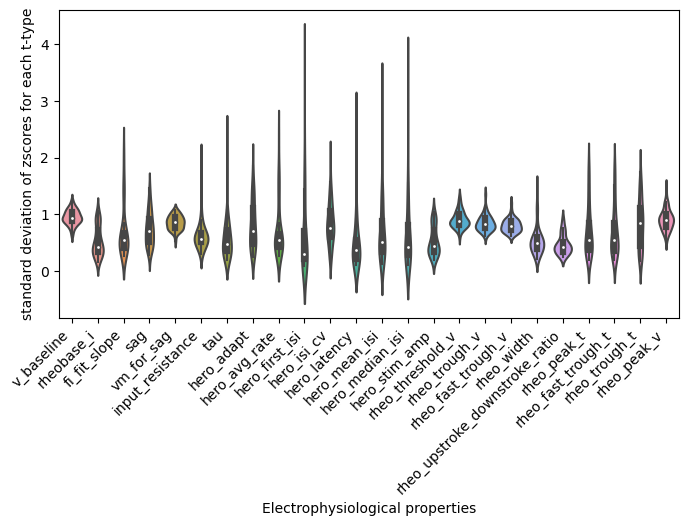

In [192]:
plt.figure(figsize=(8, 4))
ephys_prop_sc.groupby("ttype").std()\
    .melt()\
    .pipe(sns.violinplot, x="variable", y="value")
plt.xlabel("Electrophysiological properties")
plt.ylabel("standard deviation of zscores for each t-type")
xticks = plt.xticks(rotation=45, ha='right')

### low read coverage and PSI

In [3]:
import pyarrow.parquet as pq

In [1]:
output_dir = "/nethome/kcni/nxu/CIHR/proc/response_to_reviewers/"
gtf_path = "/external/rprshnas01/netdata_kcni/stlab/Genomic_references/Ensembl/Mouse/Release_104/Raw/Mus_musculus.GRCm39.104.gtf"

In [4]:
# read in the intron count matrix and features
X = pq.read_table(f"{output_dir}X.parquet").to_pandas()
features = pq.read_table(f"{output_dir}features.parquet").to_pandas()
features.strand.replace({"0": "NA", "1": "+", "2": "-"}, inplace=True)

In [6]:
n_total_SJ = features.shape[0]

In [7]:
n_total_SJ

168194

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(results, x = "n", y = "n_introns_detected")

# How many isoforms are undiscovered due to insufficient coverage?

true_indices = features.groupby("start").size() > 1
true_indices = true_indices.where(true_indices == True).dropna().index.tolist()
num_shared_start_sites = features.loc[features.start.isin(true_indices)].shape[0]

true_indices = features.groupby("end").size() > 1
true_indices = true_indices.where(true_indices == True).dropna().index.tolist()
num_shared_end_sites = features.loc[features.end.isin(true_indices)].shape[0]

with open("/external/rprshnas01/netdata_kcni/stlab/Nuo/CIHR/proc/adata_three_tt.pkl", "rb") as f:
    adata_three_tt = pickle.load(f)
with open("/external/rprshnas01/netdata_kcni/stlab/Nuo/CIHR/proc/adata_five_tt.pkl", "rb") as f:
    adata_five_tt = pickle.load(f)
adata_three_tt.layers["PSI"] = calculate_PSI(adata_three_tt, smooth=False)
adata_five_tt.layers["PSI"] = calculate_PSI(adata_five_tt, smooth=False)    

num_isoforms_explored_three = (np.isnan(adata_three_tt.layers["PSI"]).sum(axis=0) < 5).sum()
num_isoforms_explored_five = (np.isnan(adata_five_tt.layers["PSI"]).sum(axis=0) < 5).sum()

f, ax = plt.subplots(figsize=(5, 4))
results\
    .append(pd.Series({'n': "> 20", 'n_introns_detected': num_isoforms_explored_three}), ignore_index=True)\
    .append(pd.Series({'n': "total", 'n_introns_detected': num_shared_start_sites}), ignore_index=True)\
    .pipe(sns.barplot, x = "n", y = "n_introns_detected", color = "blue", ax=ax)
ax.set(ylabel="", xlabel="number of splice variants detected")